In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
games = pd.read_csv('games.csv')
players = pd.read_csv('players.csv')
plays = pd.read_csv('plays.csv.zip')
week1 = pd.read_csv('week1.csv.zip')
tyler_data_frame = pd.read_csv('tyler_data_frame - tyler_data_frame.csv')

In [3]:
# make 'gameClock' values to a datetime value from string
plays['gameClock'] = pd.to_datetime(plays['gameClock'],format= '%H:%M:%S' ).dt.time

def gameidtoT(i, col):
    return games[games['gameId'] == i][col].values[0]

plays['homeTeamAbbr'] = plays['gameId'].apply(gameidtoT, col='homeTeamAbbr')
plays['visitorTeamAbbr'] = plays['gameId'].apply(gameidtoT, col='visitorTeamAbbr')

winning_team_list = list()
for i in range(0, len(plays)):
    home_score = plays.loc[i, 'preSnapHomeScore']
    away_score = plays.loc[i, 'preSnapVisitorScore']
    home_team = plays.loc[i, 'homeTeamAbbr']
    away_team = plays.loc[i, 'visitorTeamAbbr']
    if home_score > away_score:
        winning_team = home_team
    elif away_score > home_score:
        winning_team = away_team
    else:
        winning_team = 'Tied'
    winning_team_list.append(winning_team)

winning_team_array = np.array(winning_team_list)
plays['TeamWinning'] = winning_team_array

playsq4 = plays[plays['quarter'] == 4] # plays from the fourth quarter

import datetime
fourmin = datetime.time(4, 0, 0)
playsq4_4min = playsq4[playsq4['gameClock'] <= fourmin]
difference = abs(playsq4_4min['preSnapHomeScore'] - playsq4_4min['preSnapVisitorScore'])

final = playsq4_4min[(difference <= 8) & (difference >=4)]

final = final.drop(final[final['TeamWinning'] == final['possessionTeam']].index)
final = final.reset_index(drop=True)

teamWin = tyler_data_frame['TeamWin']
def tylertoW(i):
    return tyler_data_frame[tyler_data_frame['gameId'] == i]['TeamWin'].values[0]

final['teamWin'] = final['gameId'].apply(tylertoW)

final = final.set_index(['gameId','playId'])

In [4]:
firstplayof4m = final.reset_index().set_index(['gameId']).groupby('gameId')['playId'].min()
plays2 = plays.set_index(['gameId','playId'])

In [5]:
final=final.reset_index()

def heldorblown(i):
    fpof = firstplayof4m[firstplayof4m.index == i].loc[i]
    #firstrow = final.loc[(i, fpof)]
    firstrow = final[(final['gameId'] == i) & (final['playId'] == fpof)]
    if firstrow['TeamWinning'].values[0] == firstrow['teamWin'].values[0]:
        return 'held'
    else:
        return 'blown'
    
final['heldOrBlown'] = final['gameId'].apply(heldorblown)

final = final.set_index(['gameId','playId'])

In [6]:
check = final.reset_index()
gameIds = np.unique(check['gameId'])
change_to_blown = []
for i in range(0, 77):
    count = 0
    first_play = firstplayof4m.loc[gameIds[i]]
    first_row = final.loc[(gameIds[i], first_play)]
    team_winning_initially = first_row['TeamWinning']
    plays_wanted = playsq4_4min[playsq4_4min['gameId'] == gameIds[i]]
    index_of_plays_for_this_game = plays_wanted[plays_wanted['gameId'] ==  gameIds[i]]['playId'].values
    index_of_plays_for_this_game = index_of_plays_for_this_game[index_of_plays_for_this_game >= first_play]
    for j in range(0, len(index_of_plays_for_this_game)):
        individual_play_row = plays_wanted.loc[plays_wanted['playId'] == index_of_plays_for_this_game[j]]
        current_team_winning = individual_play_row['TeamWinning']
        if current_team_winning.values[0] != team_winning_initially:
            count = count + 1
    if count > 0:
        if team_winning_initially == first_row['teamWin']:
            change_to_blown.append(gameIds[i])
change_to_blown

[2018091603,
 2018093002,
 2018093004,
 2018100701,
 2018101401,
 2018101412,
 2018102109,
 2018102803,
 2018111800,
 2018120912,
 2018122310]

In [7]:
for i in change_to_blown:
    final.loc[(i),'heldOrBlown'] = 'blown'

In [8]:
final

playDescription  quarter  \
gameId     playId                                                               
2018090600 4142    (2:19) (Shotgun) M.Ryan pass short right to A....        4   
           4166    (2:01) (No Huddle, Shotgun) M.Ryan pass deep m...        4   
           4207    (1:54) (Shotgun) M.Ryan pass incomplete short ...        4   
           4239    (1:50) (Shotgun) M.Ryan sacked at PHI 40 for -...        4   
           4258    (1:25) (No Huddle, Shotgun) M.Ryan pass deep l...        4   
...                                                              ...      ...   
2018123008 4368    (1:34) (No Huddle, Shotgun) D.Prescott pass in...        4   
           4390    (1:28) (Shotgun) D.Prescott pass incomplete sh...        4   
           4412    (1:24) (Shotgun) D.Prescott pass incomplete sh...        4   
           4457    (1:19) (Shotgun) D.Prescott pass incomplete de...        4   
2018122201 3745    (2:54) (Shotgun) P.Rivers pass short left to A...        4   

                   down  yardsToGo possessionTeam        playType  \
gameId     playId                                                   
2018090600 4142       1         10            ATL  play_type_pass   
           4166       2          4            ATL  play_type_pass   
           4207       1         10            ATL  play_type_pass   
           4239       2         10            ATL  play_type_sack   
           4258       3         17            ATL  play_type_pass   
...                 ...        ...            ...             ...   
2018123008 4368       1         10            DAL  play_type_pass   
           4390       2         10            DAL  play_type_pass   
           4412       3         10            DAL  play_type_pass   
           4457       4         15            DAL  play_type_pass   
2018122201 3745       1         20            LAC  play_type_pass   

                  yardlineSide  yardlineNumber offenseFormation  \
gameId     playId                                                 
2018090600 4142            ATL              25          SHOTGUN   
           4166            ATL              31          SHOTGUN   
           4207            PHI              33          SHOTGUN   
           4239            PHI              33          SHOTGUN   
           4258            PHI              40          SHOTGUN   
...                        ...             ...              ...   
2018123008 4368            NYG              27          SHOTGUN   
           4390            NYG              27            EMPTY   
           4412            NYG              27          SHOTGUN   
           4457            NYG              32          SHOTGUN   
2018122201 3745            BAL              49          SHOTGUN   

                         personnelO  ...  passResult  offensePlayResult  \
gameId     playId                    ...                                  
2018090600 4142    1 RB, 1 TE, 3 WR  ...           C                  6   
           4166    1 RB, 1 TE, 3 WR  ...           C                 36   
           4207    1 RB, 1 TE, 3 WR  ...           I                  0   
           4239    1 RB, 1 TE, 3 WR  ...           S                 -7   
           4258    1 RB, 1 TE, 3 WR  ...           C                 18   
...                             ...  ...         ...                ...   
2018123008 4368    1 RB, 1 TE, 3 WR  ...           I                  0   
           4390    1 RB, 1 TE, 3 WR  ...           I                  0   
           4412    1 RB, 1 TE, 3 WR  ...           I                  0   
           4457    1 RB, 1 TE, 3 WR  ...           C                 32   
2018122201 3745    1 RB, 1 TE, 3 WR  ...           C                 11   

                  playResult       epa  isDefensivePI  homeTeamAbbr  \
gameId     playId                                                     
2018090600 4142            6 -0.068448          False           PHI   
           4166           36  1.948070  

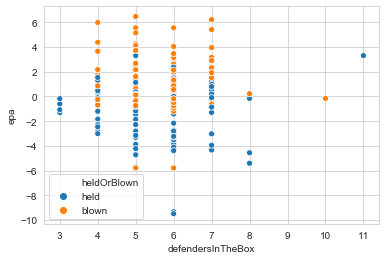

In [9]:
sns.scatterplot('defendersInTheBox','epa',hue='heldOrBlown',data=final)

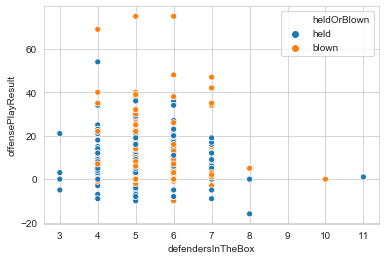

In [10]:
sns.scatterplot('defendersInTheBox','offensePlayResult',hue='heldOrBlown',data=final)

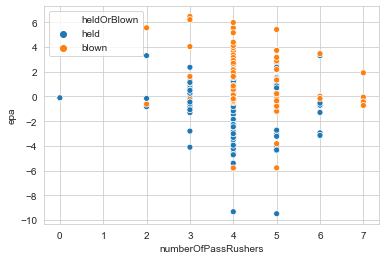

In [11]:
sns.scatterplot('numberOfPassRushers','epa',hue='heldOrBlown',data=final)

In [12]:
held = final[final['heldOrBlown'] == 'held'].reset_index()
blown = final[final['heldOrBlown'] == 'blown'].reset_index()

In [13]:
# each index of the array reprensents number of pass rushers
normal = final.reset_index()
def percentOfPassRushersPerGame(gameid, df):
    pass_rushers = np.array(df[df['gameId'] == gameid]['numberOfPassRushers'])
    number_of_plays = len(pass_rushers)
    pass_rush_list = []
    for i in range(0, 8):
        pass_rush_list.append(len(pass_rushers[pass_rushers == i]) / number_of_plays)
    return np.array(pass_rush_list)

def percentOfPassRushersByDataFrame(dataframe, df):
    final_array = np.zeros(8)
    game_ids = np.unique(dataframe['gameId'])
    for i in range(0, len(game_ids)):
        final_array = final_array + percentOfPassRushersPerGame(game_ids[i], df)
    final_array = final_array / len(game_ids)
    return final_array

held_lead_pass_rushers = pd.Series(percentOfPassRushersByDataFrame(held, normal))
blown_lead_pass_rushers = pd.Series(percentOfPassRushersByDataFrame(blown, normal))

average_held_lead_pass_rushers = 0
for i in range(0, 8):
    average_held_lead_pass_rushers = average_held_lead_pass_rushers + (held_lead_pass_rushers[i] * i)
print(average_held_lead_pass_rushers)

average_blown_lead_pass_rushers = 0
for i in range(0, 8):
    average_blown_lead_pass_rushers = average_blown_lead_pass_rushers + (blown_lead_pass_rushers[i] * i)
print(average_blown_lead_pass_rushers)

3.9541079487887996
4.121825396825397


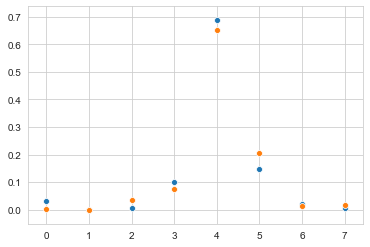

In [14]:
sns.scatterplot(x=np.arange(0,8),y=held_lead_pass_rushers)
sns.scatterplot(x=np.arange(0,8),y=blown_lead_pass_rushers)

In [15]:
antifinal_plays = plays.set_index(['gameId','playId'])
for i in final.index.get_level_values(0).unique():
    # drop all games that are represented in df=final
    antifinal_plays.drop(index=i,axis=0,level=0,inplace=True)
for i in antifinal_plays.index.get_level_values(0).unique():
    # drop all games represented in df=antifinal from plays2
    # this results in a df that has all the plays for games represented in df=final
    plays2.drop(index=i,axis=0,inplace=True)
for i in final.index.values:
    # drop (gameid,playid) tuples that are found in final (plays2 = every play not in df=final)
    plays2.drop(index=i,axis=0,inplace=True)
    
plays2.reset_index(inplace=True)
# add column w the team that won to df
plays2['teamWin'] = plays2['gameId'].apply(tylertoW)

# make a df of all unique gameId,possessionTeam combinations from final
# this gets us the defensive possesions of the team that was winning from final
unique_gamepos = list(dict.fromkeys(list(zip(final.reset_index()['gameId'], final['possessionTeam']))))
unique_gameposdf = pd.DataFrame(unique_gamepos).set_index(0)
for i in np.arange(0,len(plays2)):
    # drop the row if the team on defense is not the same as the one in final 
    if plays2.loc[i]['possessionTeam'] != unique_gameposdf.loc[plays2.loc[i]['gameId']].values[0]:
        plays2.drop(index=i,axis=0,inplace=True)
plays2.reset_index(drop=True,inplace=True)

/Users/kentoabeywardane/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [16]:
# make a df of all unique gameId,held/blown combinations from final
gameid_heldblown = pd.DataFrame(list(dict.fromkeys(list(zip(final.reset_index()['gameId'], final['heldOrBlown']))))).set_index(0)

def gameidtoHB(i):
    """input a gameId and return whether the leading team held or blew the lead"""
    return gameid_heldblown.loc[i].values[0]

plays2['heldOrBlown'] = plays2['gameId'].apply(gameidtoHB)

In [17]:
# get df's only where teams held or blew the lead
held2 = plays2[plays2['heldOrBlown'] == 'held'].reset_index()
blown2 = plays2[plays2['heldOrBlown'] == 'blown'].reset_index()

# use percentOfPassRushersByDataFrame function
held_lead_pass_rushers2 = pd.Series(percentOfPassRushersByDataFrame(held2, plays2))
blown_lead_pass_rushers2 = pd.Series(percentOfPassRushersByDataFrame(blown2, plays2))

# get average # of passrushers for teams that held the lead prior to a lead with under 4 min to go
average_held_lead_pass_rushers2 = 0
for i in range(0, 8):
    average_held_lead_pass_rushers2 = average_held_lead_pass_rushers2 + (held_lead_pass_rushers2[i] * i)
print(average_held_lead_pass_rushers2)

# get average # of passrushers for teams that blew the lead prior to a lead with under 4 min to go
average_blown_lead_pass_rushers2 = 0
for i in range(0, 8):
    average_blown_lead_pass_rushers2 = average_blown_lead_pass_rushers2 + (blown_lead_pass_rushers2[i] * i)
print(average_blown_lead_pass_rushers2)

4.070694699662195
4.095852870758585


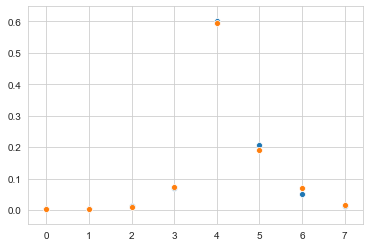

In [18]:
sns.scatterplot(x=np.arange(0,8),y=held_lead_pass_rushers2)
sns.scatterplot(x=np.arange(0,8),y=blown_lead_pass_rushers2)

In [19]:
held_lead_pass_rushers2 - held_lead_pass_rushers

0   -0.030871
1    0.002947
2    0.005724
3   -0.031258
4   -0.084940
5    0.059780
6    0.032062
7    0.006351
dtype: float64

In [39]:
held_changedf = pd.concat([held_lead_pass_rushers2, 
                           held_lead_pass_rushers, 
                           held_lead_pass_rushers-held_lead_pass_rushers2], axis=1)
blown_changedf = pd.concat([blown_lead_pass_rushers2, 
                            blown_lead_pass_rushers, 
                            blown_lead_pass_rushers-blown_lead_pass_rushers2], axis=1)

In [40]:
held_changedf.rename(columns={0:'before',1:'after',2:'change'},inplace=True)
blown_changedf.rename(columns={0:'before',1:'after',2:'change'},inplace=True)
held_changedf.reset_index(inplace=True)
blown_changedf.reset_index(inplace=True)

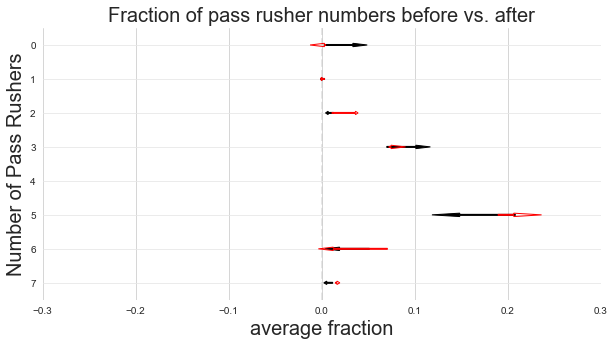

In [81]:
ax = plt.figure(figsize=(10,5))

#add start points
ax = sns.stripplot(data=held_changedf, 
                   x='before', 
                   y='index', 
                   orient='h', 
                   order=held_changedf['index'], 
                   size=0, 
                   color='black')

#define arrows
arrow_starts = held_changedf['before'].values
arrow_lengths = held_changedf['change'].values

#add arrows to plot
for i, index in enumerate(held_changedf['index']):
    ax.arrow(arrow_starts[i],        #x start point
             i,                      #y start point
             arrow_lengths[i],       #change in x 
             0,                      #change in y
             head_width=0.1,         #arrow head width
             head_length=abs(arrow_lengths[i]/2),        #arrow head length
             width=0.03,              #arrow stem width
             fc='black',             #arrow fill color
             ec='black')             #arrow edge color
    
#add start points
ax = sns.stripplot(data=blown_changedf, 
                   x='before', 
                   y='index', 
                   orient='h', 
                   order=blown_changedf['index'], 
                   size=0, 
                   color='red')

#define arrows
arrow_starts2 = blown_changedf['before'].values
arrow_lengths2 = blown_changedf['change'].values

#add arrows to plot
for i, index in enumerate(blown_changedf['index']):
    ax.arrow(arrow_starts2[i],        #x start point
             i,                      #y start point
             arrow_lengths2[i],       #change in x 
             0,                      #change in y
             head_width=0.1,         #arrow head width
             head_length=abs(arrow_lengths[i]/2),        #arrow head length
             width=0.03,              #arrow stem width
             fc=(0,0,0,0),             #arrow fill color
             ec='red')             #arrow edge color

    
#format plot
ax.set_title('Fraction of pass rusher numbers before vs. after',fontsize=20)   #add title
ax.axvline(x=0, color='0.9', ls='--', lw=2, zorder=0) #add line at x=0
ax.grid(axis='y', color='0.9')                        #add a light grid
ax.set_xlim(-0.3,0.3)                                 #set x axis limits
ax.set_xlabel('average fraction',fontsize=20)                     #label the x axis
ax.set_ylabel('Number of Pass Rushers',fontsize=20)               #label the y axis
sns.despine(left=True, bottom=True)                   #remove axes